In [257]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import warnings
import networkx as nx
import random
import seaborn as sns
import time
from collections import deque
import heapq
from itertools import product

style.use("seaborn-white")
plt.rc("figure", figsize=(20, 10))
plt.rc("font", size=20)
plt.rc("legend", fontsize=20)
warnings.filterwarnings("ignore")

In [384]:
# graph representation methods
def get_adj_matrix(v=100, e=200):
    assert v * (v - 1) / 2 >= e, 'Too many edges for this number of vertices'
    adj_matrix = np.zeros((v, v))
    k = 0
    while k < e:
        i, j = random.randint(0, v - 1), random.randint(0, v - 1)
        if adj_matrix[i, j] == 0 and i != j:
            weight = random.random()
            adj_matrix[i, j] = weight
            adj_matrix[j, i] = weight
            k += 1
    return adj_matrix

def get_adj_list_from_graph(graph):
    return {i[0]: list(i[1].keys()) for i in graph.adjacency()}

def make_connected_graph(v, e, attempts=20):
    i = 0
    while i < attempts:
        adj_matrix = get_adj_matrix(v=v, e=e)
        g = nx.from_numpy_matrix(adj_matrix)
        if nx.is_connected(g):
            return g
        i += 1
    print("Too many graphs with several components, try to increase E or decrease V")
    return None

In [460]:
g = make_connected_graph(v=50, e=200)

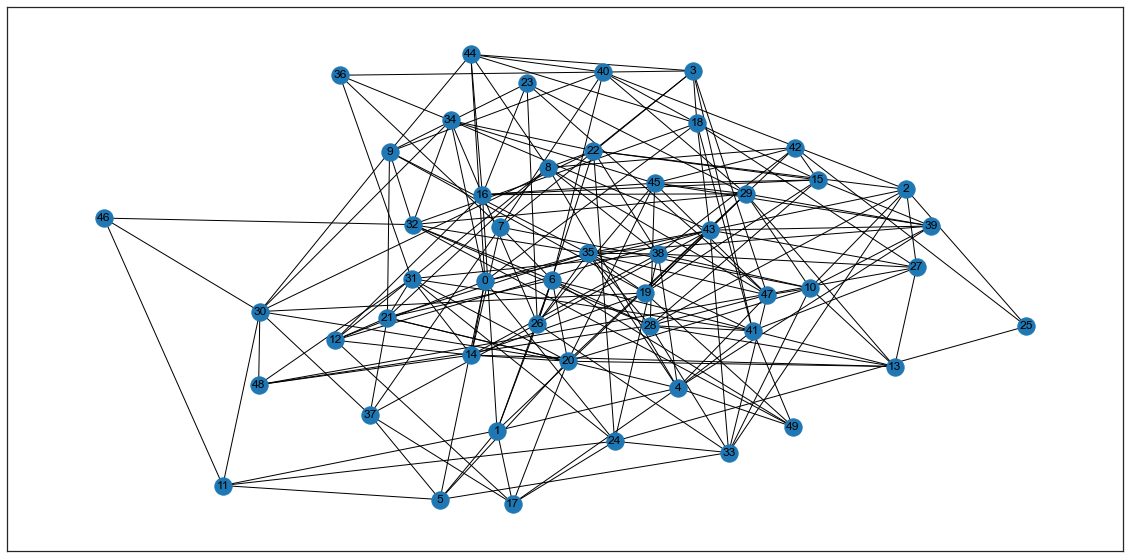

In [461]:
nx.draw_networkx(g, with_labels=True)

In [188]:
class DisjointSet:
    def __init__(self, x_list):
        self.data = [-1] * len(x_list)
        self.rank = [0] * len(x_list)
        for x in x_list:
            self.data[x] = x
            self.rank[x] = 0

    def find(self, x):
        if x == self.data[x]:
            return x
        else:
            self.data[x] = self.find(self.data[x])
            return self.data[x]

    def union(self, x, y):
        x_parent = self.find(x)
        y_parent = self.find(y)
        
        if x_parent == y_parent:
            return
        
        if self.rank[x_parent] < self.rank[y_parent]:
            self.data[x_parent] = y_parent
        elif self.rank[x_parent] > self.rank[y_parent]:
            self.data[y_parent] = x_parent
        else:
            self.data[y_parent] = x_parent
            self.rank[x_parent] += 1

In [470]:
def kruskal(graph):
    result = []
    graph_set = DisjointSet(list(graph.nodes))
    edges = sorted(list(graph.edges.data()), key=lambda x: x[2]['weight'])

    e = 0
    for u, v, w in edges:
        if e > len(graph_set.data):
            break
        x = graph_set.find(u)
        y = graph_set.find(v)
        if x != y:
            e = e + 1
            result.append([u, v, w['weight']])
            graph_set.union(x, y)
    return result

def prim(graph, starting_vertex=0):
    adj_list = dict(graph.adjacency())
    result = list()
    visited = set([starting_vertex])
    edges = [
        (starting_vertex, to, cost['weight'])
        for to, cost in adj_list[starting_vertex].items()
    ]
    heapq.heapify(edges)

    while edges:
        frm, to, cost = heapq.heappop(edges)
        if to not in visited:
            visited.add(to)
            result.append((frm, to, cost))
            for to_next, cost in adj_list[to].items():
                if to_next not in visited:
                    heapq.heappush(edges, (to, to_next, cost['weight']))

    return result

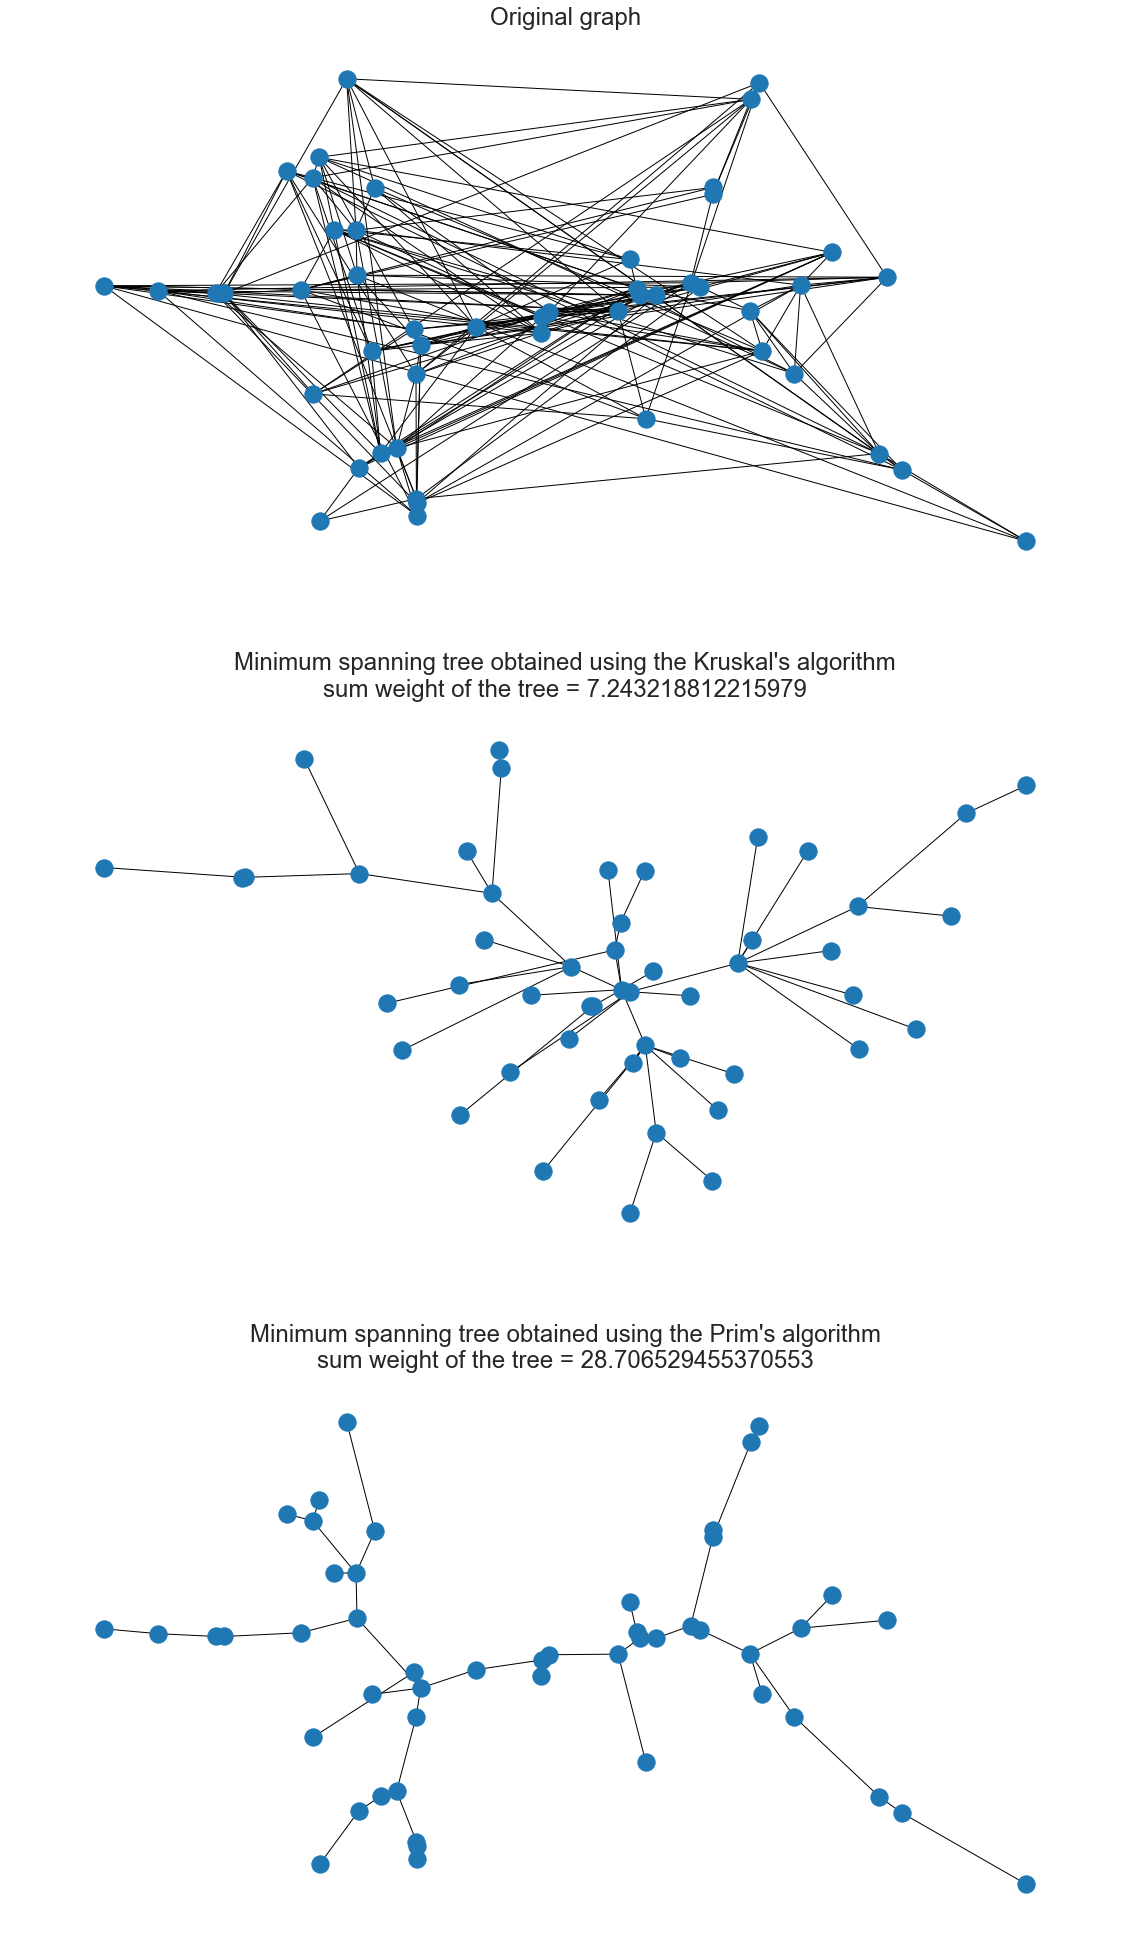

In [508]:
layout = nx.layout.kamada_kawai_layout
_, axes = plt.subplots(nrows=3, figsize=(20, 35))
prim_result = prim(g, starting_vertex=0)
kruskal_result = kruskal(g)
tree_kruskal = g.edge_subgraph([(i[0], i[1]) for i in prim_result])
tree_prim = g.edge_subgraph([(i[0], i[1]) for i in kruskal_result])
nx.draw(g, pos=layout(tree_prim), ax=axes[0])
nx.draw(tree_kruskal, pos=layout(tree_kruskal), ax=axes[1])
nx.draw(tree_prim, pos=layout(tree_prim), ax=axes[2])
axes[0].title.set_text('Original graph')
axes[1].title.set_text("Minimum spanning tree obtained using the Kruskal's algorithm\n"
                       f"sum weight of the tree = {sum([i[2] for i in kruskal_result])}")
axes[2].title.set_text("Minimum spanning tree obtained using the Prim's algorithm\n"
                       f"sum weight of the tree = {sum([i[2] for i in prim_result])}")

In [476]:
# results of Prim's algorithm for different starting vertex
for i in range(50):
    prim_result = prim(g, starting_vertex=i)
    print(i, sum([i[2] for i in prim_result]))

0 28.706529455370553
1 27.88640778204916
2 25.052523807767468
3 26.24899312464408
4 27.88640778204916
5 28.706529455370553
6 27.88640778204916
7 26.24899312464408
8 27.886407782049165
9 27.38939137708088
10 25.052523807767468
11 27.88640778204916
12 28.706529455370553
13 25.052523807767468
14 28.706529455370553
15 27.958691354636315
16 27.88640778204916
17 27.88640778204916
18 28.706529455370553
19 27.38939137708088
20 28.706529455370557
21 27.886407782049165
22 25.052523807767468
23 27.38939137708088
24 28.706529455370553
25 25.052523807767468
26 27.88640778204916
27 25.052523807767468
28 25.052523807767468
29 27.88640778204916
30 27.38939137708088
31 27.88640778204916
32 27.886407782049165
33 25.052523807767464
34 28.706529455370553
35 28.706529455370553
36 26.248993124644077
37 28.706529455370553
38 27.88640778204916
39 27.88640778204916
40 25.052523807767464
41 26.24899312464408
42 27.88640778204916
43 28.706529455370553
44 28.706529455370553
45 27.958691354636315
46 27.88640778204

In [396]:
# methods for measuring and plotting perfomances of algorithms
def measure_time_complexity(method, v_e, max_minutes=5):    
    times = list()
    exp_start = time.time()
    for v, e in v_e:
        n_trials = 5
        graphs = [make_connected_graph(v=v, e=e) for _ in range(n_trials)]
        start_time = time.process_time()
        try:
            for i in range(n_trials):
                method(graphs[i])
            times.append((time.process_time() - start_time) / n_trials)
        except OverflowError:
            print(f'Overflow on {n}-th step')
            break
        if time.time() - exp_start > 60 * max_minutes:
            print(f'Time limit ({max_minutes} minutes) exceeded on {n}-th step')
            break
    return times

def get_approx(times, approx_predictor, poly_degree=1):
    coef = np.polynomial.polynomial.polyfit(
        approx_predictor(np.arange(len(times))+1), times, poly_degree
    )
    approx_f = 0
    for i, c in enumerate(coef):
        approx_f += c * approx_predictor(np.arange(len(times))+1) ** i
    return approx_f

In [397]:
v = [100]
e = list(range(300, 1000))
v_e = list(product(v, e))
prim_times = measure_time_complexity(prim, v_e)
kruskal_times = measure_time_complexity(kruskal, v_e)

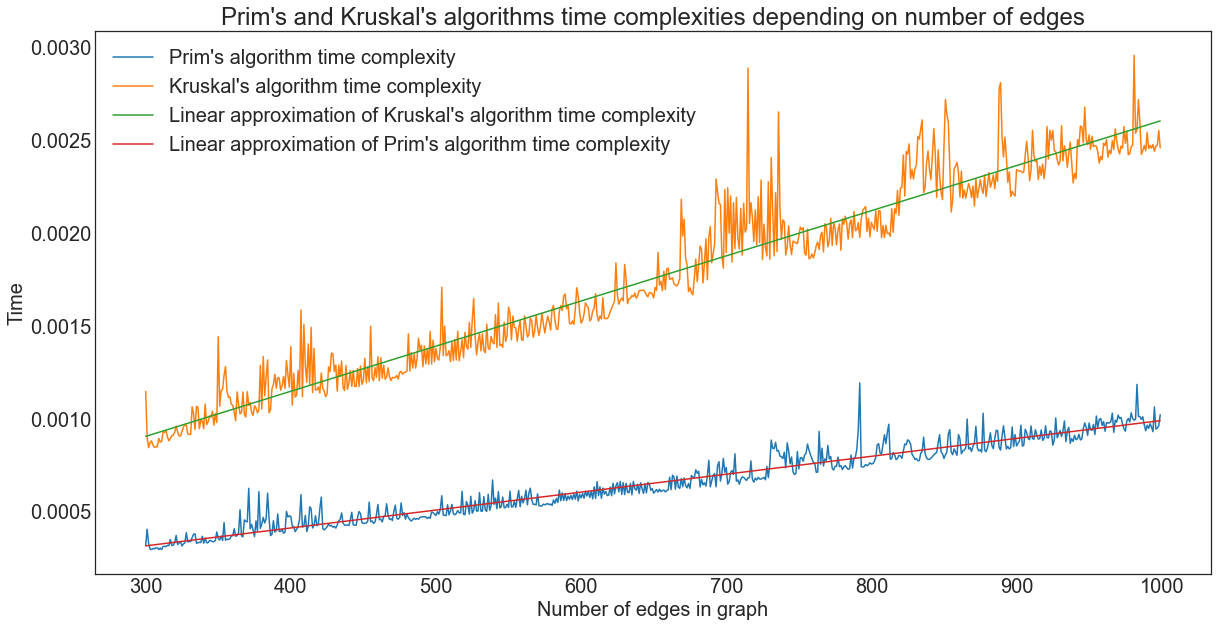

In [400]:
plt.plot(e, prim_times, label="Prim's algorithm time complexity")
plt.plot(e, kruskal_times, label="Kruskal's algorithm time complexity")
plt.plot(e, get_approx(kruskal_times, lambda x: x), label="Linear approximation of Kruskal's algorithm time complexity")
plt.plot(e, get_approx(prim_times, lambda x: x), label="Linear approximation of Prim's algorithm time complexity")
plt.title("Prim's and Kruskal's algorithms time complexities depending on number of edges");
plt.xlabel("Number of edges in graph")
plt.ylabel("Time")
plt.legend()

In [451]:
np.mean([kruskal_times[i] / prim_times[i] for i in range(len(kruskal_times))])

2.7201214532799254

In [ ]:
v = list(range(50, 400))
e = [1200]
v_e = list(product(v, e))
prim_times_v = measure_time_complexity(prim, v_e)
kruskal_times_v = measure_time_complexity(kruskal, v_e)

In [ ]:
plt.plot(v, prim_times_v, label="Prim's algorithm time complexity")
plt.plot(v, kruskal_times_v, label="Kruskal's algorithm time complexity")
plt.plot(v, get_approx(kruskal_times_v, lambda x: np.log(x+min(v))), 
         label="Logarithmic approximation of Kruskal's algorithm time complexity")
plt.plot(v, get_approx(prim_times_v, lambda x: np.log(x+min(v))), 
         label="Logarithmic approximation of Prim's algorithm time complexity")
plt.title("Prim's and Kruskal's algorithms time complexities depending on number of vertices");
plt.xlabel("Number of vertices in graph")
plt.ylabel("Time")
plt.legend()

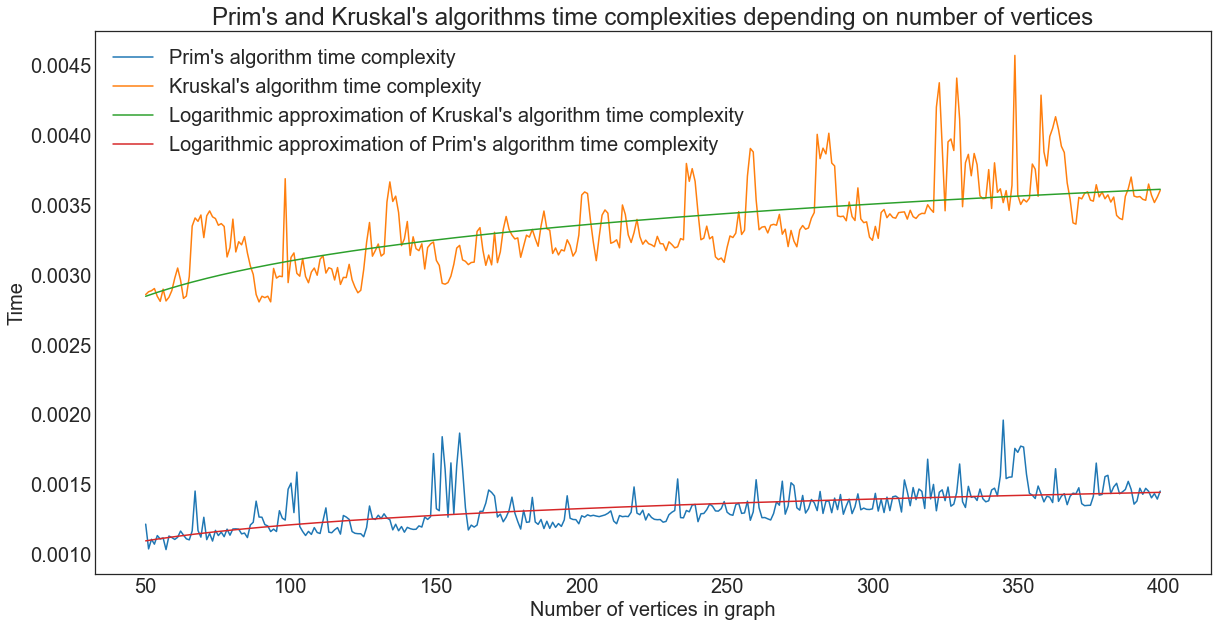

In [447]:
plt.plot(v, prim_times_v, label="Prim's algorithm time complexity")
plt.plot(v, kruskal_times_v, label="Kruskal's algorithm time complexity")
plt.plot(v, get_approx(kruskal_times_v, lambda x: np.log(x+min(v))), 
         label="Logarithmic approximation of Kruskal's algorithm time complexity")
plt.plot(v, get_approx(prim_times_v, lambda x: np.log(x+min(v))), 
         label="Logarithmic approximation of Prim's algorithm time complexity")
plt.title("Prim's and Kruskal's algorithms time complexities depending on number of vertices");
plt.xlabel("Number of vertices in graph")
plt.ylabel("Time")
plt.legend()